Process edges for testing:
- Take in line data from Luis' team
- Translate and rotate

Tests in scope:
- Smoothed inflection point detection
- Downsampling + direct vector comparison
-

Set up basic test data:

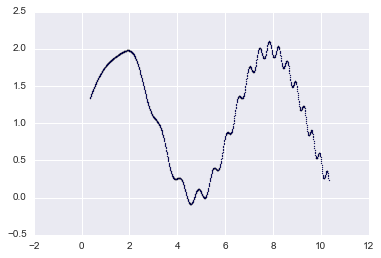

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import helpers
%matplotlib inline

SMOOTHING_FACTOR = 30

X = np.arange(0,10,0.01)+0.34
Y = np.sin(X) + 0.1 * np.sin(X**2+3) + 1
testdata = np.array([X,Y]).T
plt.scatter(testdata[:,0],testdata[:,1], s=1)

In [121]:
def axis_align(inputdata):
    # Translate leftermost point to the origin
    translateddata = inputdata - inputdata[0]
    
    # Find an assumed "straight edge" line: 
    # straight line between first and last points
    leftpoint = translateddata[0]
    rightpoint = translateddata[-1]
    slope = (rightpoint[1] - leftpoint[1]) / (rightpoint[0] - leftpoint[0])
    
    # NOTE: can we get c,s more smartly?
    theta = np.arctan(slope)
    c, s = np.cos(theta), np.sin(theta)
    rotationmatrix = np.matrix('{} {}; {} {}'.format(c, -s, s, c))
    
    newdata =  translateddata * rotationmatrix
    # plt.scatter(newdata[:,0], newdata[:,1])
    
    scalefactor = newdata[-1,0]
    #print(scalefactor)
    newdata[:,0] = newdata[:,0] / scalefactor
    
    return newdata
    
aligned_data = axis_align(testdata)

We have processed lines.

Find locations of juts by smoothing locally (keep as variable smoothing parameter for now)

[ 1.55013396  4.33014179  4.73873855  4.80273828  7.41392241]


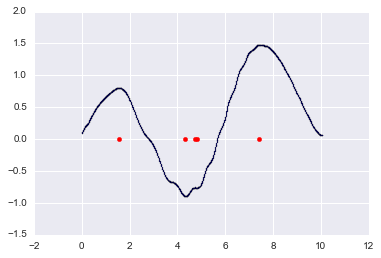

In [113]:
def _kernel_smoother(linedata, pointref, d):
    # Return the smoothed value of f(linedata[pointref])
    
    # Kernel average smoother: take the d nearest points on either side and use their f values
    # as a weighted average for f(x).
    leftlim = max(0, pointref - d)
    rightlim = min(len(linedata), pointref + d)

    weightwindow = np.concatenate( [np.array([(i+1) for i in range(pointref-leftlim)]),
                                   np.array([(d-i) for i in range(rightlim-pointref)])])
    weightwindow = weightwindow / np.sum(weightwindow)
    
    #print(np.sum(weightwindow)
    vals = linedata[leftlim: rightlim][:,1]
    #print(vals.shape, weightwindow.shape)
    #print(vals)
    fx = np.sum(np.multiply(np.squeeze(vals), weightwindow))
    #print(fx)
    return fx

def smooth(linedata):
    Xsmooth = np.array(linedata[:,0]).flatten()
    Ysmooth = [_kernel_smoother(linedata, i, SMOOTHING_FACTOR) for i in range(len(linedata))]
    testdata = np.array([Xsmooth, Ysmooth]).T
    return testdata

def inflection_anal(linedata):
    smoothed = smooth(linedata)
    gradients = np.gradient(smoothed[:,1])

    inflectionmask = [(gradients[i] * gradients[i+1] <= 0) for i in range(len(gradients)-1)]
    
    inflectionrefs = [i for i in range(len(inflectionmask)) if inflectionmask[i]]
    inflectionpoints = smoothed[inflectionrefs,0]
    
    return inflectionrefs, inflectionpoints

smoothed_data = smooth(aligned_data)
inflectionrefs, inflectionpoints = inflection_anal(aligned_data)
print(inflectionpoints)
plt.scatter(smoothed_data[:,0], smoothed_data[:,1], s=1)
plt.scatter(inflectionpoints,[0]*len(inflectionpoints), color='r')


In [114]:
def msdev(linedata):
    total = np.multiply(linedata[:,1], linedata[:,1])
    return np.sum(total)/len(linedata)

msdev(aligned_data)


0.63354434472063337

In [122]:
inputcsv = np.genfromtxt('sample_csv/74584_MS-DAR-00125-000-00073_north.csv', delimiter=',')
inputcsv = inputcsv[1:,(1,2)]
print(inputcsv.shape)

inputcsv.sort(0)

aligned_data = axis_align(inputcsv)

# plt.scatter(inputcsv[:,0],inputcsv[:,1])
# plt.scatter(aligned_data[:,0], aligned_data[:,1])

(3792, 2)


In [117]:
def get_aligneddata(filename):
    inputcsv = np.genfromtxt(filename, delimiter=',')
    inputcsv = inputcsv[1:,(1,2)]
    inputcsv.sort(0)
    aligned_data = axis_align(inputcsv)
    return aligned_data

def get_msdev(filename):
    return msdev(aligned_data)

In [118]:
import os 

for i in os.listdir("sample_csv"):
    name = "sample_csv/" + i
    print(name, msdev(get_aligneddata(name)))

sample_csv/74584_MS-DAR-00125-000-00073_north.csv 465.703029291
sample_csv/74584_MS-DAR-00125-000-00073_south.csv 6.8097390376
sample_csv/74584_MS-DAR-00125-000-00073_west.csv 3408.17920444
sample_csv/76748_MS-DAR-00053-00001-000-00118_north.csv 3.19860339829
sample_csv/76748_MS-DAR-00053-00001-000-00118_south.csv 528.912322452
sample_csv/76748_MS-DAR-00053-00001-000-00118_west.csv 0.0
sample_csv/77726_MS-DAR-00205-00001-000-00096_north.csv 1.96121793027
sample_csv/77726_MS-DAR-00205-00001-000-00096_south.csv 9820.61101075


3792 3699


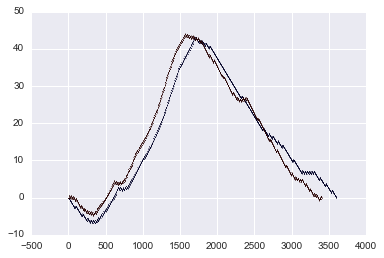

In [119]:
al1 = get_aligneddata("sample_csv/74584_MS-DAR-00125-000-00073_north.csv")
plt.scatter(al1[:,0], al1[:,1], s=0.1)

al2 = get_aligneddata("sample_csv/76748_MS-DAR-00053-00001-000-00118_south.csv")
plt.scatter(al2[:,0], al2[:,1], s=0.1, c='r')

print(len(al1), len(al2))

/Users/Mike/Documents/darwin/darwin-cluster/helpers.py:17: RuntimeWarning: unorderable types: str() > int(), sort order is undefined for incomparable objects
  downsampled = downsampled.append(chunk_avg, ignore_index=True)


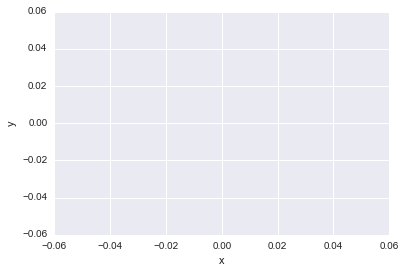

In [133]:
import pandas as pd
al1 = helpers.downsample(pd.DataFrame(al1))
#plt.scatter(al1[:,0], al1[:,1], s=0.1)

al2 = helpers.downsample(pd.DataFrame(al2))
al1.plot(kind="scatter", x='x', y='y')